<a href="https://colab.research.google.com/github/SiliconJackets/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/accepted_notebooks/SJSystolicArray/SystolicArray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Row Stationary Systolic Array With Openlane

```
Copyright 2024 SiliconJackets @ Georgia Institute of Technology
SPDX-License-Identifier: GPL-3.0-or-later
```

Running a 3x3 systolic array design inspired by [EYERISS](https://courses.cs.washington.edu/courses/cse550/21au/papers/CSE550.Eyeriss.pdf) design thru the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) GDS to RTL flow targeting the [open source SKY130 PDK](https://github.com/google/skywater-pdk/).

|Name|Affiliation| Email |IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|:----------:|
|Zachary Ellis|Georgia Institute of Technology|zellis7@gatech.edu|Yes|Yes|
|Nealson Li|Georgia Institute of Technology|nealson@gatech.edu|Yes|Yes|
|Addison Elliott|Georgia Institute of Technology|addisonelliott@gatech.edu|No|No|
|Zeyan Wu|Georgia Institute of Technology|zwu477@gatech.edu|No|No|
|Jingsong Guo|Georgia Institute of Technology|guojingsong@gatech.edu|No|No|

This notebook goes through the process of design specification, simulation, and implementation of a Systolic Array with open-source tools and PDKs. The parallel computation and data reuse ability of a systolic array is crucial for the acceleration of neural networks, and this notebook with the reusable design aims to contribute to the hardware open-source community to enable more efficient ML applications. This project will explain the principles behind how a systolic array operates 2D convolution, demonstrate the performance of our implementation with image results, and show the final GDS generated with open-source flow. Additionally, to further demonstrate the feasibility of the open-source flow and our design, we are also submitting this systolic array design to the open-source silicon initiative, [Tiny Tapeout](https://tinytapeout.com/). This submission is completed by members of SiliconJackets. We are a student run organization at Georgia Tech that introduces students to semiconductor design, verification, and implementation through a large collaborative project. We are hoping to use this notebook as an example for future members of the club.



<!-- In this notebook we will be going through the process of design specification, simulation, and implementation for a resource constrained design intended to submitted to another open source silicon initiative [Tiny Tapeout](https://tinytapeout.com/). Tiny tapeout allows individuals to purchase tiny 160um x 100um blocks on a silicon die for an acceptable price in order to gain exposure to the semiconductor deisng process. Our plan is to create a hardware accelerator for Convolutional Neural Networks \(CNNs\), losely based on the design from [EYERISS](https://courses.cs.washington.edu/courses/cse550/21au/papers/CSE550.Eyeriss.pdf) for the purpose of recognizing hardwritten numbers. This project will demonstrate the principles behind how a systolic array operates for doing 2D convolution operators, demonstrate the performance of our implementation, and show how the final design can fit within *a few* tiny tapeout blocks. -->


<!-- From the github page

1. Promote reproducible chip design using open-source tools and notebook-driven design flows and
2. Enable up-and-coming talents as well as seasoned open-source enthusiasts to travel to IEEE SSCS conferences and interact with the leading-edge chip design community.

Applicants must submit an open-source Jupyter notebook detailing an innovative circuit design using open-source tools. The objective is to disseminate the main ideas and design choices using open-source tools and PDKs in a reproducible manner. Generating a final layout of your circuit is encouraged but not required. -->


## Introduction
---


In this noteboook, we will first explain what a systolic array is and its application by referencing the row stationary data flow introduced in [EYERISS](https://courses.cs.washington.edu/courses/cse550/21au/papers/CSE550.Eyeriss.pdf), which our design is losely based on. Then, the hardware specification and design of the high level architecture and processing unit are explained. We will then demonstrate the performance by simulating the hardware design to perform convolution for an edge detection task, and verify it with the software golden referrence. Lastly, the systolic array is pushed through [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) RTL to GDS flow with the open-source [SKY130 PDK](https://github.com/google/skywater-pdk/).

## Systolic Array
---

### What is a Systolic Array

A systolic array is a 2D array of individual processing elements, which can each independently compute. Systolic arrays allow massive parallel computation which is largely useful for machine learning applications which can require a large number of MACs (Multiply and Accumulates) that are not dependent on one another. This array construction not only allows the massive parallel computation abilities, but also facilitates data reuse which reduces the memory bottleneck. By scheduling operations correctly for something like matrix multiplication of 2D+ convolution, PEs that are next to each other may use similar data in their operations. Because of the PE arrangement, this data can be passed between PEs directly, which means it only has to be fetched once from memory. In this notebook we present a 3x3 systolic array which uses row stationary dataflow and show how it passes data between PEs for maximum data reuse and minimum required bandwidth.

### Convolutions and Systolic Arrays
In the realm of signal processing and machine learning, convolution plays a fundamental role in various applications such as image processing, video processing, and digital filtering. A two-dimensional convolution (Conv2D) is a mathematical operation involving sliding a filter matrix over a larger input matrix to produce an output, which is a fundamental operation in many algorithms, including those employed in computer vision and machine learning applications.
The convolution operation naturally allows for significant data reuse, as any value from the input, filter, or output matrices will be used many times in different multiplication/addition calculations (MACs). The key to exploiting this opportunity for efficient convolutions is to use highly parallel hardware to reuse data loaded from memory as much as possible before it's returned to memory.
In a systolic array, data is loaded from memory and flows through a grid of identical processing elements (PEs), being reused differently in each PE over different clock cycles. The flow of data through the system can be compared to the flow of blood being pumped through the circulatory system.
Systolic arrays are very useful for matrix multiplication (GEMM), and before the row-stationary (RS) dataflow was used, convolution operations were converted into large GEMM operations before they could flow through the array of PEs. However, with the modified RS dataflow which we implemented in our design, the systolic-like array directly computes the Conv2D of the input and filter matrix efficiently.

#### Row Stationary Dataflow

In a row stationary dataflow, the individual processing elements in a systolic array each have small amounts of scratchpad memory which is devoted to keep row value data in place while it is operated on. In this mode, each processing element computes a single output from a 1D convolution operation and then those partial sums are added down the columns for the final outputs. During the initial loading of the filter weights and row data, the full scratchpads need to be populated before any computation can occur, but as the convolution operation moves across the rows, only one new byte of data needs to be read per PE making this form of 2D convolution operation very memory efficient.

<div>
<img src="https://github.com/sscs-ose/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/accepted_notebooks/SJSystolicArray/img/systolic_array_flow.gif?raw=1" width="1000"/>
</div>

<!-- ![Flow](https://github.com/SiliconJackets/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/submitted_notebooks/SJSystolicArray/img/systolic_array_flow.gif?raw=true){: width=250} -->

#### Applications

The main application for row stationary systolic arrays is 2D convolution. A convolution operation applies a filter kernel to a 2D input (for example an image) which then transforms the image to pull out specific details. A convolution may be able to pick out the edges of objects as shown in this notebook, or a chain of convolutions such as in a convolutional neural network may be able to filter out more complex shapes for object recognition or something like a dog. Using a systolic array to do 2D convolution is very quick and efficient which is why this hardware is the basis for many machine learning accelerators.

### How is the hardware designed?

In order to show off the high memory efficiency of row stationary dataflow, the external memory connections for the top level of this design are very limited. With 2 read ports and 1 write port, this design is only able to read in 16 bits of data each cycle and write 8 bits. However, this data is reused across PEs allowing up to 9 MACs a cycle with different data combinations.

<div>
<img src="https://github.com/sscs-ose/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/accepted_notebooks/SJSystolicArray/img/Top.png?raw=1" width="1000"/>
</div>

<!-- ![Flow](https://github.com/SiliconJackets/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/submitted_notebooks/SJSystolicArray/img/Top.png?raw=true){: width=250} -->

#### Top Level Design

The top-level controller is responsible for controlling the timing of data read and operation start for all the PEs. Taking in the size of the input from the memory interface on the first cycle, the top-level controller then schedules the control signals for the individual PEs to read the data on the memory bus when it is their turn. When a PE has the data it needs, and it is it's turn in the sequence to start it's 1D convolution, the top-level controller asserts the start signal for that PE. Because of the staggering of start times, the state machines inside the PEs will run such that the data is automatically summed up the column of the PE and only one result is available for writing at a time.

<div>
<img src="https://github.com/sscs-ose/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/accepted_notebooks/SJSystolicArray/img/Ctrl.png?raw=1" width="1000"/>
</div>

<!-- ![Flow](https://github.com/SiliconJackets/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/submitted_notebooks/SJSystolicArray/img/Ctrl.png?raw=true){: width=250} -->

#### PE Design

In order to reduce complexity and area the control structure inside each PE is kept very simple. When the PE sees a control signal to read in a new input or filter value from the top-level controller, it will read in a new value into the scratchpad and shift existing values over evicting the oldest value (with a depth of 3). Once the PE sees a start signal it will spend 3 cycles doing MACs with the scratchpad values and then sum with the input psum. With the PE start signals staggered across the array, the psum_o for one PE in a column becomes psum_i for the PE above it with the top PE presenting a final value at the output. These PEs always rely on the correct data being present at the correct time which is possible with the scheduling of the memory transactions and top-level controller.

<div>
<img src="https://github.com/sscs-ose/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/accepted_notebooks/SJSystolicArray/img/PE.png?raw=1" width="1000"/>
</div>

<!-- ![Flow](https://github.com/SiliconJackets/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/submitted_notebooks/SJSystolicArray/img/PE.png?raw=true){width=250} -->

## Simulation
---

### Edge Detection with 2D Convolution accelarated by Systolic Array
<!-- Explain convolving the input image with sobel filter emhances the edge of the objects, and the convolution can be accelerated by the Systolic array. -->

To demonstrate our systolic array's ability to accelerate convolution operation, we are performing Canny edge detection which requires convolving an image. The edges of an image are enhanced after it is convolved with Sobel filters in x and y direction separately. The filters are 3x3 kernels show as below:

$$\text{Sobel Filter x} =
\begin{bmatrix}
-0.5 & 0 & 0.5 \\
-1.0 & 0 & 1.0 \\
-0.5 & 0 & 0.5
\end{bmatrix}$$

$$\text{Sobel Filter y} =
\begin{bmatrix}
-0.5 & -1.0 & -0.5 \\
0 & 0 & 0 \\
0.5 & 1.0 & 0.5
\end{bmatrix}$$

The results are the first derivative in the x and y directions, $grad_x$ and $grad_y$, we can then iterate through all the pixels and calculate the intensity gradient of the image, which represents the edges, with:

$$\text{Grad Intensity} = \sqrt{grad_x ^ 2 + grad_y ^ 2}$$

We have a python implementation of the Canny edge detection algorithm as our golden reference to verify or systolic array design. Dedicated data sequence generator is developed with the hardware architecture data flow to process the image and kernels and generate input sequence to the systolic array. The example image that undergoes the convolution operation in both the hardware simulation and the software is:

<div>
<img src="https://github.com/sscs-ose/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/accepted_notebooks/SJSystolicArray/src/python/rubiks_cube.jpg?raw=1"/>
</div>

The demonstration has following steps:
1. Install the software dependencies
2. Download the python and verilog files of our design
3. Run convolution in both software and hardware:

    a. Grayscale and resize the input image to 256 by 256
    
    b. In software, performe convolution and generate the golden image
    
    c. In hardware, performe convolution

    d. In software, process the hardware result and generate the output image

4. Compare the golden image and the output image

We would first demonstrate with the rubik's cube image, after this example you can upload any image to try it out, and see how well the systolic array accelerated edge detection is performing.


<!--
Explain image size, show original image.

Explain the following experiment steps -->

In [2]:
#@title Install Dependencies {display-mode: "form"}
#@markdown Click the ▷ button to setup the simulation environment.

#@markdown Main components we will install

#@markdown *   verilator : a free and open-source software tool which converts Verilog (a hardware description language) to a cycle-accurate behavioral model in C++ or SystemC.
#@markdown *   pytorch : Used to format input data for the systolic array from the image files and do edge detection in software for the golden reference
#@markdown *   opencv : Used for input image manipulation
#@markdown *   fxpmath : This module helps emulate the floating point math behavior of our systolic array

%load_ext autoreload
%autoreload 2
!apt-get install verilator
!pip install torch
!pip install torchvision
!pip install opencv-python
!pip install fxpmath
!pip install numpy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libsystemc libsystemc-dev
Suggested packages:
  gtkwave
The following NEW packages will be installed:
  libsystemc libsystemc-dev verilator
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 5,473 kB of archives.
After this operation, 25.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsystemc amd64 2.3.3-5.1 [500 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsystemc-dev amd64 2.3.3-5.1 [241 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 verilator amd64 4.038-1 [4,732 kB]
Fetched 5,473 kB in 1s (3,657 kB/s)
Selecting previously unselected package libsystemc:amd64.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../libsystemc_2.3.3-5.1_amd64.deb ...
Unpacking libsystemc:amd

In [1]:
%%capture

#@title Download Systolic Array Files

#@markdown Click the ▷ button to download the rtl files.
#@markdown The files will be downloaded to the SytolicArray directory
#@markdown the file structure is described below:

#@markdown *   SystolicArray/src
#@markdown    *  python/
#@markdown       *   `canny.py` : python implementation of the Canny Edge Detection algorithm
#@markdown       *   `full_flow.py` : performes the edge detection on a given image with either software or hardware
#@markdown       *   `rubiks_cube.jpg` : the default example image
#@markdown       *   `seq_generator.py` : generates the Systolic Array input sequence from the image and kernel
#@markdown    *   `PE.sv` : This is the implementation of an individual processing element that is instantiated in a 3x3 array
#@markdown    *   `tb_top.cpp` : This is the verilator testbench used for running image data through the systolic array
#@markdown    *   `top.sv` : This is the top level file where all modules are instantiated and connected to each other / IO ports
#@markdown    *   `topLevelControl.sv` : This module generates control signals for all of the PEs based on the size of the input. It coordinates data loading as well as starts the 1D convolution operations in each PE

%cd /content/
!rm -rf SystolicArray
!git clone https://github.com/sscs-ose/sscs-ose-code-a-chip.github.io.git SystolicArray
!mv SystolicArray/VLSI24/accepted_notebooks/SJSystolicArray/src SystolicArray/
!mv SystolicArray/VLSI24/accepted_notebooks/SJSystolicArray/img SystolicArray/
!rm -rf SystolicArray/ISSCC23/
!rm -rf SystolicArray/ISSCC24/
!rm -rf SystolicArray/VLSI23/
!rm -rf SystolicArray/VLSI24/
!rm SystolicArray/*.md
!rm SystolicArray/LICENSE

### Compile Verilator Testbench

In [3]:
%cd /content/
!rm -rf obj_dir
!verilator --trace --cc SystolicArray/src/top.sv SystolicArray/src/topLevelControl.sv SystolicArray/src/PE.sv --exe SystolicArray/src/tb_top.cpp
!make -C obj_dir -f Vtop.mk Vtop

/content
make: Entering directory '/content/obj_dir'
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=1 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-parameter -Wno-unused-variable -Wno-shadow      -Os -c -o tb_top.o ../SystolicArray/src/tb_top.cpp
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=1 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-parameter -Wno-unused-variable -Wno-shadow      -Os -c -o verilated.o /usr/share/verilator/include/verilated.cpp
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=1 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unu

### Run 2D Convolution in both Software and Hardware
Using full_flow.py, we run an image through a software only version of the edge detection algorithm to get a golden reference. Then we generate `seq_x.txt`, and `seq_y.txt` which are used as input data for the verilator testbench. The results from verilator are collected by the script and written to the image file `edge_rubiks_cube_sa.jpg` all files can be found in the `SystolicArray/src/python/` directory.

In [4]:
%cd /content/SystolicArray/src/python/
!python3 full_flow.py rubikscube

/content/SystolicArray/src/python
/content/SystolicArray/src/python/full_flow.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ifmap = torch.load('img_0.pt').squeeze()//

Text(0.5, 1.0, 'Systolic Array Edge Detection')

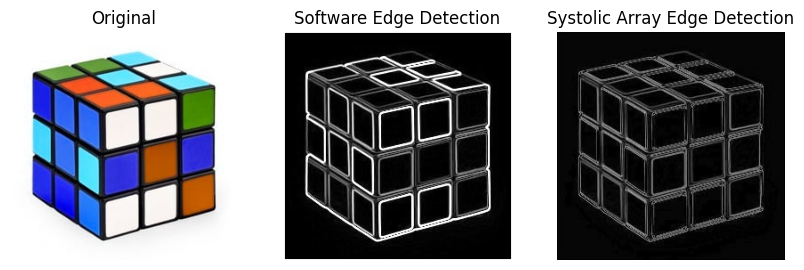

In [5]:
#@title Compare Results

#@markdown Because the hardware is limited to 8 bit integer math, the output is not as bright as the software version, but it is still able to achieve a similar looking result


# code for displaying multiple images in one figure

#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 1
columns = 3

# reading images
Image1 = cv2.imread('/content/SystolicArray/src/python/rubiks_cube.jpg')
Image2 = cv2.imread('/content/SystolicArray/src/python/edge_rubiks_cube.jpg')
Image3 = cv2.imread('/content/SystolicArray/src/python/edge_rubiks_cube_sa.jpg')

#Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Original")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Software Edge Detection")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Systolic Array Edge Detection")


### Try it yourself

In [ ]:
#@markdown Click the ▷ button to upload your own image for edge detection

from google.colab import files
import ipywidgets as widgets
from IPython.display import display, clear_output

UPLOADED = False

def upload_image(_):
    clear_output()
    upload_widget = widgets.FileUpload(accept='.jpg', multiple=False)
    display(upload_widget)
    upload_widget.observe(save_image, names='value')

def save_image(change):
    global UPLOADED
    if change.new:
        uploaded_filename = next(iter(change.new))
        content = change.new[uploaded_filename]['content']
        with open('/content/SystolicArray/src/python/uploadedimage.jpg', 'wb') as f:
            f.write(content)
            UPLOADED = True
        print('Image successfully uploaded!')
    else:
        print('Please select a file.')

upload_button = widgets.Button(description="Upload Image")
upload_button.on_click(upload_image)
display(upload_button)

FileUpload(value={}, accept='.jpg', description='Upload')

Image successfully uploaded!


/content/SystolicArray/src/python


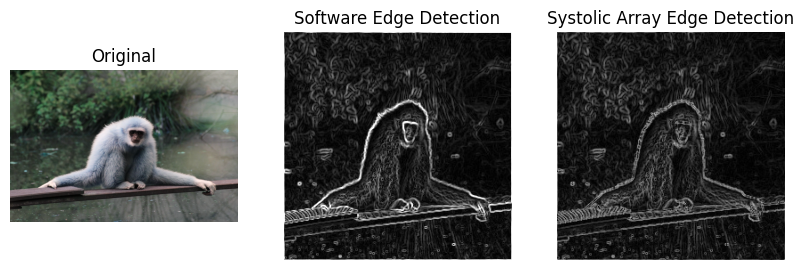

In [ ]:
#@markdown Click the ▷ button to start the demonstration with your image

%cd /content/SystolicArray/src/python/
import cv2
from matplotlib import pyplot as plt
if not UPLOADED:
    print("First, upload a jpg in the cell above")
else:
    !python3 full_flow.py userinput
    #@markdown Because the hardware is limited to 8 bit integer math, the output is not as bright as the software version, but it is still able to achieve a similar looking result


    # code for displaying multiple images in one figure


    # create figure
    fig = plt.figure(figsize=(10, 7))

    # setting values to rows and column variables
    rows = 1
    columns = 3

    # reading images
    Image1 = cv2.imread('/content/SystolicArray/src/python/uploadedimage.jpg')
    Image2 = cv2.imread('/content/SystolicArray/src/python/edge_uploadedimage.jpg')
    Image3 = cv2.imread('/content/SystolicArray/src/python/edge_uploadedimage_sa.jpg')

    #Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)

    # showing image
    plt.imshow(Image1)
    plt.axis('off')
    plt.title("Original")

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    # showing image
    plt.imshow(Image2)
    plt.axis('off')
    plt.title("Software Edge Detection")

    # Adds a subplot at the 3rd position
    fig.add_subplot(rows, columns, 3)

    # showing image
    plt.imshow(Image3)
    plt.axis('off')
    plt.title("Systolic Array Edge Detection")

### RTL2GDS Flow

In [ ]:
#@markdown We need to remove the previously installed version of Verilator and also install libparse in order for OpenLane to function properly. In order for everything to run the first time in the notebook we will also need to restart the runtime. Once you click the ▷ button for this cell, at the bottom it will prompt you **Once deleted, variables cannot be recovered. Proceed (y/[n])?** Please type y
!apt remove -y verilator
!pip install libparse
%reset

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package 'verilator' is not installed, so not removed
The following packages were automatically installed and are no longer required:
  libsystemc libsystemc-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
#@title Install Dependencies {display-mode: "form"}
#@markdown Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

#@markdown Main components we will install

#@markdown *   Open_pdks.sky130a : a PDK installer for open-source EDA tools.
#@markdown *   Openlane : an automated RTL to GDSII flow based on several components including OpenROAD, Yosys, Magic, Netgen, CVC, SPEF-Extractor, KLayout and a number of custom scripts for design exploration and optimization.
#@markdown *   GDSTK : a C++ library for creation and manipulation of GDSII and OASIS files.

!apt remove -y verilator
#openlane_version = 'custom_set' #@param {type:"string"}
#open_pdks_version = 'custom_set' #@param {type:"string"}

#if openlane_version == 'latest':
#  openlane_version = ''
#if open_pdks_version == 'latest':
#  open_pdks_version = ''

import os
import pathlib

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={"2023.11.03_0_gf4f8dad8"} \
                     open_pdks.sky130a={"1.0.458_0_g8c68aca"} \
                     openroad={"2.0_10927_g0922eecb9"} \
                     verilator={"5.018_57_ga022b672a"}
!bin/micromamba install --quiet \
                        --yes \
                        --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        --channel main \
                        gdstk

!pip install libparse libparse
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
#%reset

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package 'verilator' is not installed, so not removed
The following packages were automatically installed and are no longer required:
  libsystemc libsystemc-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Empty environment created at prefix: /content/conda-env

Pinned packages:
  - python 3.7*


Transaction

  Prefix: /content/conda-env

  Updating specs:

   - openlane=2023.11.03_0_gf4f8dad8
   - open_pdks.sky130a=1.0.458_0_g8c68aca
   - openroad=2.0_10927_g0922eecb9
   - verilator=5.018_57_ga022b672a


  Package                                                Version  Build                 Channel         Size
──────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:
%%writefile config.json
{
    "DESIGN_NAME": "top",
    "VERILOG_FILES": "dir::SystolicArray/src/*.sv",
    "CLOCK_PERIOD": 40,
    "CLOCK_NET": "clk",
    "CLOCK_PORT": "clk",

    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 480 200",
    "PL_TARGET_DENSITY": 0.8
}

Overwriting config.json


### Run Flow
In the event that the flow fails due to a verilator (linter) or libparse (on step 34) error please restart runtime and rerun install dependencies. Just re-running install dependencies may work as well

In [ ]:
%env PDK=sky130A
!flow.tcl -design .

env: PDK=sky130A
OpenLane 2023.11.03_0_gf4f8dad8-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library: sky130_fd_sc_hd
[INFO]: Run Directory: /content/runs/RUN_2024.04.15_18.01.03
[INFO]: Saving runtime environment...
[INFO]: Preparing LEF files for the nom corner...
[INFO]: Preparing LEF files for the min corner...
[INFO]: Preparing LEF files for the max corner...
[WARNING]: PNR_SDC_FILE is not set. It is recommended to write a custom SDC file for the design. Defaulting to BASE_SDC_FILE
[WARNING]: SIGNOFF_SDC_FILE is not set. It is recommended to write a custom SDC file for the design. Defaulting to BASE_SDC_FILE
[INFO]: Running linter (Verilator) (log: 

In [ ]:
#@title View Results
#@markdown Click the ▷ button to generate an SVG from the GDS
#@markdown in our testing sometimes the svg does not show or is too large to render properly so we have converted to png offline for viewing. The result is displayed below
import pathlib
import gdstk

gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('systolicarray.svg')

<div>
<img src="https://github.com/sscs-ose/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/accepted_notebooks/SJSystolicArray/img/systolicarray.jpg?raw=true" width="1000"/>
</div>

<!-- ![Flow](https://github.com/SiliconJackets/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/submitted_notebooks/SJSystolicArray/img/systolicarray
.png?raw=true){width=250} -->